In [17]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

In [18]:
required_fields = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base',
       'taker_buy_quote', 'ignore']

In [19]:
def fetch_binance_15m_1yr(symbol="BTCUSDT", required_columns=None):
    """
    Fetch last 1 year of 15-minute interval OHLCV data from Binance.
    Optionally return only the columns specified in required_columns.
    close_time is always used as index.
    """
    
    base_url = "https://api.binance.com/api/v3/klines"
    interval = "15m"

    # Timezone-aware UTC timestamps
    now_utc = datetime.now(timezone.utc)
    start_dt = now_utc - timedelta(days=365)

    end_time = int(now_utc.timestamp() * 1000)
    start_time = int(start_dt.timestamp() * 1000)

    all_candles = []
    current_start = start_time

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": current_start,
            "endTime": end_time,
            "limit": 1000
        }

        response = requests.get(base_url, params=params)
        data = response.json()

        if not data:
            break

        all_candles.extend(data)

        last_close_time = data[-1][6]
        current_start = last_close_time + 1

        if last_close_time >= end_time:
            break

        time.sleep(0.1)


    # Full Binance kline schema
    columns = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]

    df = pd.DataFrame(all_candles, columns=columns)

    # Convert timestamps
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms", utc=True)

    # Numeric OHLCV
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].astype(float)
    print(df.head())
    # Filter columns if needed
    if required_columns is not None:
        # Ensure close_time is kept for indexing
        cols = required_columns.copy()
        if "close_time" not in cols:
            cols.append("close_time")  # must keep for index

        df = df[cols]

    # Set close_time as index
    df = df.set_index("close_time")
    df = df.sort_index()

    return df


In [20]:
required_fields = ['open', 'high', 'low', 'close', 'volume', 'open_time', 'taker_buy_base']

In [21]:
df = fetch_binance_15m_1yr("BTCUSDT", required_fields)
df.head()


                  open_time      open      high       low     close  \
0 2024-12-02 12:30:00+00:00  95386.14  95407.64  95080.85  95080.86   
1 2024-12-02 12:45:00+00:00  95080.85  95087.98  94766.00  94972.02   
2 2024-12-02 13:00:00+00:00  94972.03  95490.37  94837.77  95399.83   
3 2024-12-02 13:15:00+00:00  95399.84  95743.66  95397.31  95690.65   
4 2024-12-02 13:30:00+00:00  95690.64  95822.61  95567.44  95577.74   

      volume                       close_time quote_asset_volume  \
0  299.14374 2024-12-02 12:44:59.999000+00:00  28500938.30744970   
1  352.27560 2024-12-02 12:59:59.999000+00:00  33440488.79115880   
2  389.06173 2024-12-02 13:14:59.999000+00:00  37015563.24691190   
3  478.14614 2024-12-02 13:29:59.999000+00:00  45715430.00070570   
4  445.23818 2024-12-02 13:44:59.999000+00:00  42607065.28153600   

   number_of_trades taker_buy_base    taker_buy_quote ignore  
0             54583   110.43173000  10523316.48987370      0  
1             61861   139.92863000  13

,open,high,low,close,volume,open_time,taker_buy_base
close_time,,,,,,,
2024-12-02 12:44:59.999000+00:00,95386.14,95407.64,95080.85,95080.86,299.14374,2024-12-02 12:30:00+00:00,110.43173000
2024-12-02 12:59:59.999000+00:00,95080.85,95087.98,94766.00,94972.02,352.27560,2024-12-02 12:45:00+00:00,139.92863000
2024-12-02 13:14:59.999000+00:00,94972.03,95490.37,94837.77,95399.83,389.06173,2024-12-02 13:00:00+00:00,213.37077000
2024-12-02 13:29:59.999000+00:00,95399.84,95743.66,95397.31,95690.65,478.14614,2024-12-02 13:15:00+00:00,272.74969000
2024-12-02 13:44:59.999000+00:00,95690.64,95822.61,95567.44,95577.74,445.23818,2024-12-02 13:30:00+00:00,222.18680000


In [22]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'open_time',
       'taker_buy_base'],
      dtype='object')


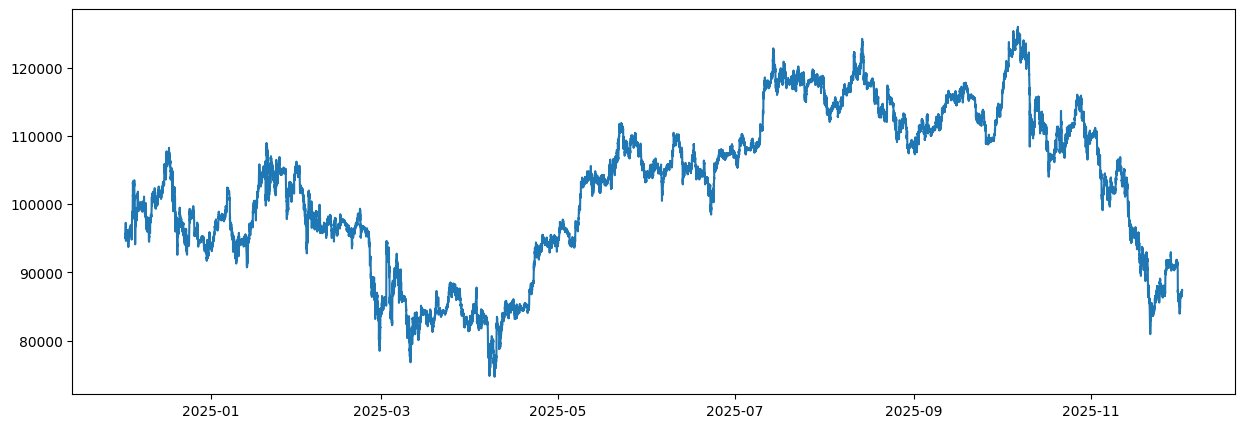

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df["close"])

In [24]:
df.to_csv("BTC_1_year_data_15m.csv")